### Open AI Gym

Reinforcement Learning with CartePole

In [1]:
# Common imports
import numpy as np
import os
import sys
import gym
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import time
%matplotlib nbagg

os.chdir('..')

In [2]:
# Utility function that hides a lot of the heavy lifting
from render_utils import *
from reward_functions import *

%load_ext autoreload
%autoreload 2

In [3]:
# ---------- Initialise CartePole -------------
env = gym.make('CartPole-v0')
obs = env.reset()
obs

array([-0.02508425, -0.01805515,  0.0179706 ,  0.03025558])

* `obs` is the new observation
* `reward` is given 1 point at every step, the goal is to keep running as long as possible
* `done` This value will be true when the episode is over
* `info` This dictionary may provide extra debug information in other environments

In [4]:
# Helper functions

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [5]:
# ----------------------------- Render Functions -----------------------------------

from PIL import Image, ImageDraw, ImageFont

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # no problem, let's use OpenAI gym's rendering function
except Exception:
    openai_cart_pole_rendering = False  # probably no X server available, let's use our own rendering function

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)    
    
def plot_environment(env, figsize=(5,4)):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    plt.show()    
    
# def render_cart_pole(env, obs, step):
#     if not openai_cart_pole_rendering:
#         # use OpenAI gym's rendering function
#         return env.render(mode="rgb_array")
#     else:
#         # rendering for the cart pole environment (in case OpenAI gym can't do it)
#         img_w = 600
#         img_h = 400
#         cart_w = img_w // 12
#         cart_h = img_h // 15
#         pole_len = img_h // 3.5
#         pole_w = img_w // 80 + 1
#         x_width = 2
#         max_ang = 0.2
#         bg_col = (255, 255, 255)
#         cart_col = 0x000000 # Blue Green Red
#         pole_col = 0x669acc # Blue Green Red

#         pos, vel, ang, ang_vel = obs
#         img = Image.new('RGB', (img_w, img_h), bg_col)
#         draw = ImageDraw.Draw(img)
#         cart_x = pos * img_w // x_width + img_w // x_width
#         cart_y = img_h * 95 // 100
#         top_pole_x = cart_x + pole_len * np.sin(ang)
#         top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
#         draw.line((0, cart_y, img_w, cart_y), fill=0)
#         draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
#         draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole

#         # --------------- Render HUD --------------------
#         font = ImageFont.truetype("arial.ttf", 18)
        
#         draw.text((cart_x - cart_w // 2 + 22 - 4*len(str(step)), 370), str(step), font=font, fill=(255,255,255,255))
        
#         return np.array(img)


### Reinforcement Learning - Policy Gradients
* The Policy Gradients algorithm tackles the problem by playing multiple games

In [7]:
import tensorflow as tf

reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits)  # probability of action 0 (left)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

y = 1. - tf.to_float(action)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [8]:
def render_policy_net(model_path, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    action_val = 0
    
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            # Send step to rendering function
            img = render_cart_pole(env, obs, step, action_val)
            frames.append(img)
            
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            
            if done:
                break
    env.close()
    return frames

In [9]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [10]:
env = gym.make("CartPole-v0")

n_games_per_update = 10
n_max_steps = 1000
n_iterations = 100
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\rIteration: {}".format(iteration), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./models/my_policy_net_pg_100epoch.ckpt")

Iteration: 99

In [11]:
env.close()

INFO:tensorflow:Restoring parameters from models/my_policy_net_pg_100epoch.ckpt


<IPython.core.display.Javascript object>


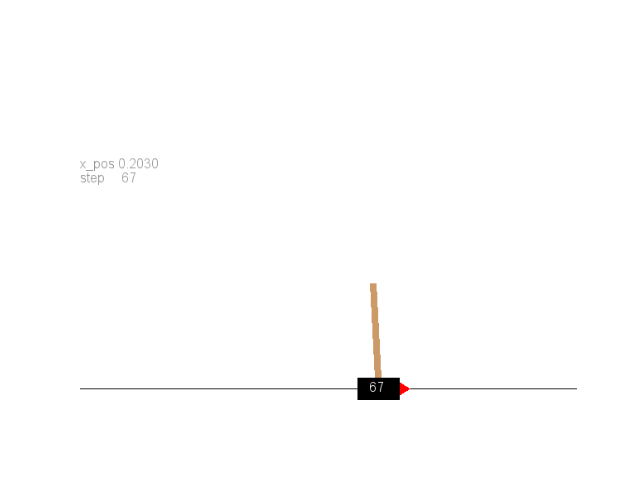

In [13]:
frames = render_policy_net("models/my_policy_net_pg_100epoch.ckpt", X, n_max_steps=2000)
video = plot_animation(frames, repeat=True)
plt.show()

In [14]:
from tqdm import tqdm_notebook

In [ ]:
# Same as above but more iterations

env = gym.make("CartPole-v0")

n_games_per_update = 10
n_max_steps = 1000
n_iterations = 500
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in tqdm_notebook(range(n_iterations)):
        print("\rIteration: {}/{}".format(iteration, n_iterations), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./models/my_policy_net_pg_500epoch.ckpt")
            print(' Avg. Frames:', np.mean([len(reward) for reward in all_rewards]))
            if np.mean([len(reward) for reward in all_rewards]) > 195: # early stopping
                break  

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

Iteration: 0/500 Avg. Frames: 24.1
Iteration: 10/500 Avg. Frames: 25.8
Iteration: 20/500 Avg. Frames: 36.2
Iteration: 28/500


Exception in thread Thread-7:
Traceback (most recent call last):
  File "C:\Users\Luke\Anaconda3\lib\threading.py", line 914, in _bootstrap_inner
    self.run()
  File "C:\Users\Luke\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Luke\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Iteration: 30/500 Avg. Frames: 44.8
Iteration: 40/500 Avg. Frames: 66.5
Iteration: 50/500 Avg. Frames: 78.7
Iteration: 60/500 Avg. Frames: 85.5
Iteration: 70/500 Avg. Frames: 122.5
Iteration: 80/500 Avg. Frames: 142.7
Iteration: 90/500 Avg. Frames: 153.1
Iteration: 100/500 Avg. Frames: 174.8
Iteration: 110/500 Avg. Frames: 190.0
Iteration: 120/500 Avg. Frames: 180.9
Iteration: 124/500

In [ ]:
frames = render_policy_net("./my_policy_net_pg_500epoch.ckpt", X, n_max_steps=2000)
video = plot_animation(frames, repeat=True)
plt.show()